<a href="https://colab.research.google.com/github/NaumanAnwar97/Demand-Forecast/blob/main/Assessment__1_AI_ProductManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a predictive model for the electrical energy output of a Combined Cycle Power Plant




### Starting with Importing the dataset using Pandas library.

In [ ]:
# import data file

import pandas as pd

df = pd.read_csv('/content/CCPP_data.csv')


In [ ]:
# Take a glimpse of the dataset
df.head(5)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
# correlation matrix

correlation_matrix = df.corr()
print(correlation_matrix)


          AT         V        AP        RH        PE
AT  1.000000  0.844107 -0.507549 -0.542535 -0.948128
V   0.844107  1.000000 -0.413502 -0.312187 -0.869780
AP -0.507549 -0.413502  1.000000  0.099574  0.518429
RH -0.542535 -0.312187  0.099574  1.000000  0.389794
PE -0.948128 -0.869780  0.518429  0.389794  1.000000


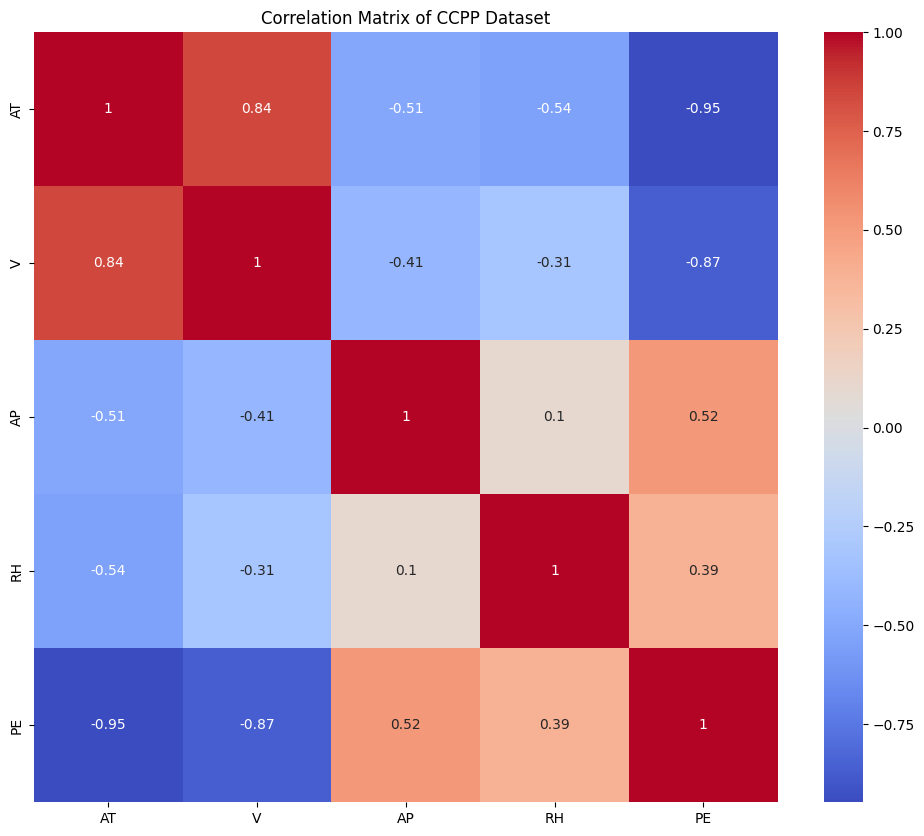

In [ ]:
# Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of CCPP Dataset')
plt.show()

### The Correlation matrix shows all the independent vairables have adequate correlation with tht target feature, therefore all these feature will be used in the model.
### However, RH has relatively weak correlation of 0.39 with the Target variable (PH).

* **Linear Regression model** seems appropriate model since we are predicting a continous variable*

In [ ]:
# split the dataset df into test and train where target variable is PE in df

from sklearn.model_selection import train_test_split

X = df.drop('PE', axis=1)
y = df['PE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### The dataset is splitted into training set and testing set using random sampling, where 20% of the observations are assigned to testing set. While 80% of the observation goes into train set.

In [ ]:
# create 5 folds validation set of df

from sklearn.model_selection import KFold

# Create a KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through the folds and print the indices of the training and validation sets
for train_index, val_index in kf.split(df):
  X_train_fold, X_val_fold = df.iloc[train_index], df.iloc[val_index]
  y_train_fold, y_val_fold = df['PE'].iloc[train_index], df['PE'].iloc[val_index]
  print(f"Train indices: {train_index}, Validation indices: {val_index}")


Train indices: [   1    2    4 ... 9564 9565 9567], Validation indices: [   0    3    8 ... 9561 9563 9566]
Train indices: [   0    1    2 ... 9564 9565 9566], Validation indices: [  26   28   34 ... 9528 9545 9567]
Train indices: [   0    1    3 ... 9565 9566 9567], Validation indices: [   2   15   25 ... 9543 9560 9564]
Train indices: [   0    1    2 ... 9565 9566 9567], Validation indices: [   6    7   16 ... 9556 9559 9562]
Train indices: [   0    2    3 ... 9564 9566 9567], Validation indices: [   1    4    5 ... 9554 9555 9565]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Initialize Random Forest models with different hyperparameters
rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_2 = RandomForestRegressor(n_estimators=200, random_state=42)

# Initialize Linear Regression model
lr_model_1 = LinearRegression()
lr_model_2 = LinearRegression()  # Linear Regression doesn't have hyperparameters to tune in the same way

# Function to evaluate model using cross-validation
def evaluate_model(model, X_train, y_train):
    mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

    return {
        'MSE': np.mean(mse),
        'MAE': np.mean(mae),
        'R2': np.mean(r2)
    }

# Compare Random Forest models
rf_eval_1 = evaluate_model(rf_model_1, X_train, y_train)
rf_eval_2 = evaluate_model(rf_model_2, X_train, y_train)

# Compare Linear Regression models
lr_eval_1 = evaluate_model(lr_model_1, X_train, y_train)
lr_eval_2 = evaluate_model(lr_model_2, X_train, y_train)

# Print results
print("Random Forest (n_estimators=100):", rf_eval_1)
print("Random Forest (n_estimators=200):", rf_eval_2)
print("Linear Regression (model_1):", lr_eval_1)
print("Linear Regression (model_2):", lr_eval_2)


Random Forest (n_estimators=100): {'MSE': 11.995405206901134, 'MAE': 2.4746839538854943, 'R2': 0.958835651153936}
Random Forest (n_estimators=200): {'MSE': 11.930950088729961, 'MAE': 2.4673593179902875, 'R2': 0.9590569197753638}
Linear Regression (model_1): {'MSE': 20.91059071055759, 'MAE': 3.6315167336508174, 'R2': 0.9282207098417876}
Linear Regression (model_2): {'MSE': 20.91059071055759, 'MAE': 3.6315167336508174, 'R2': 0.9282207098417876}


### We can see that **Random Forest** regressor has outperformed Linear regression model. Therefore, we will select **Random Forest algorithm** for final model evaluation.

In [ ]:
# Train the best model on the entire training set
best_model = rf_model_2
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics on the test set
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Print the test set performance
print("Test Set Performance:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R2: {r2_test}")


Test Set Performance:
MSE: 10.439215277724582
MAE: 2.3146691222570515
R2: 0.9640099014655094
